# visualization of the visual channel in the local branch

In [1]:
from __future__ import print_function
import sys
sys.path.append("/home/jovyan/Bert")
import torch
import torch.nn as nn
from models.net_avst_mimn_loc_glo_vis import AVQA_Fusion_Net
import ast
import json
import numpy as np
import os
import glob
from torchvision import transforms, utils
from tqdm import tqdm

from einops import rearrange

from PIL import Image
import cv2

/home/jovyan/conda-envs/czl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def TransformImage(img):

    transform_list = []
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]
    
    transform_list.append(transforms.ToPILImage())
    transform_list.append(transforms.Resize([224,224]))
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize(mean, std))
    trans = transforms.Compose(transform_list)
    frame_tensor = trans(img)
    
    return frame_tensor

In [3]:
def attn_vis(model, question, audio, imgs, ori_video):
    _, _, _, _, _, _, _, loc_att_map = model(audio, imgs, imgs, question)
    
    obj_localization = loc_att_map[0, :, :].squeeze()
    obj_localization = obj_localization.detach().numpy()
    print("ori_video: ", ori_video.shape)
    que_len = obj_localization.shape[0]
    vis_len = obj_localization.shape[1]
    for i in tqdm(range(que_len)):
        # print("obj: ", obj_localization.shape)
        map_i = np.expand_dims(obj_localization[i, :], axis=0)
        map_i = (map_i-map_i.min()) / (map_i.max()-map_i.min())
        for j in range(vis_len):
            map = np.expand_dims(map_i[:, j], axis=0)
            map=cv2.resize(map.reshape(1,1),(224,224))
            map=map/map_i.max()
            map=np.uint8(map*255)
            heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
            
            current_img = ori_video[j]
            current_img = cv2.resize(current_img, (224, 224))

            result = heatmap * 0.4 + current_img * 0.6

            file_name = '%01d_' % i + '%01d_' % j + '.jpg'
            print("file_name: ", file_name)
            cv2.imwrite(os.path.join('/home/jovyan/Bert/result_images', file_name), result)

In [6]:
def dataloader(label, audio_dir, video_dir):
    samples = json.load(open('/home/jovyan/Bert/data/json_update/avqa-train.json', 'r'))
    # nax =  nne
    ques_vocab = ['<pad>']
    i = 0
    for sample in samples:
        i += 1
        question = sample['question_content'].rstrip().split(' ')
        question[-1] = question[-1][:-1]

        p = 0
        for pos in range(len(question)):
            if '<' in question[pos]:
                question[pos] = ast.literal_eval(sample['templ_values'])[p]
                p += 1

        for wd in question:
            if wd not in ques_vocab:
                ques_vocab.append(wd)
                
    word_to_ix = {word: i for i, word in enumerate(ques_vocab)}
    samples = json.load(open(label, 'r'))
    max_len = 14  # question length
    
    question_list = []
    answer_list = []
    video_list = []
    ori_video_list = []
    audio_list = []
    for idx in tqdm(range(len(samples))):
        sample = samples[idx]
        video_name = sample['video_id']
        print('video_name: ', video_name)
        # video
        image_list = sorted(glob.glob(os.path.join(params['video_path'], video_name, '*.jpg')))
        C, H, W = 3, 224, 224
        # print(len(image_list))
        image_list = image_list[::6]
        image_list = image_list[:10]
        # print("image_list: ", image_list)
        images = torch.zeros((len(image_list), C, H, W))
        ori_images = np.zeros((len(image_list), H, W, C),dtype = float)
        # print(type(images))
        for iImg in range(len(image_list)):
            ori_img = Image.open(image_list[iImg]).convert('RGB')
            ori_img = cv2.resize(np.array(ori_img), (224, 224))
            ori_images[iImg] = ori_img
            img = cv2.imread(image_list[iImg])
            images[iImg] = TransformImage(img)
            
        video_list.append(images)
        ori_video_list.append(ori_images)
        # audio
        audio = np.load(os.path.join(params['audio_dir'], video_name + '.npy'))[::6, :]
        audio_list.append(audio)

        # question
        question = sample['question_content'].rstrip().split(' ')
        print("question: ", question)
        question[-1] = question[-1][:-1]
        p = 0
        for pos in range(len(question)):
            if '<' in question[pos]:
                question[pos] = ast.literal_eval(sample['templ_values'])[p]
                p += 1
        if len(question) < max_len:
            n = max_len - len(question)
            for i in range(n):
                question.append('<pad>')
        idxs = [word_to_ix[w] for w in question]
        # ques = torch.tensor(idxs, dtype=torch.long)
        question_list.append(idxs)
        
    question_list = torch.from_numpy(np.array(question_list)).long()
    audio_list = torch.from_numpy(np.array(audio_list).astype(np.float32))
    
    return question_list, audio_list, video_list, np.array(ori_video_list)

In [ ]:
if __name__ == '__main__':
    params = {}
    params['audio_dir'] = './data/feats/vggish'
    params['video_path'] = '/data/avst/frames_1fps/'
    params['label'] = "./data/json_update/avqa-vis.json"
    params['model_dir'] = "./data/checkpoints/checkpoint_loc_glo_attn_map"
    
    model = AVQA_Fusion_Net('').to('cpu')
    checkpoint = torch.load(os.path.join(params['model_dir'], 'best' '.tar'), map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # load visualization data
    question_list, audio_list, video_list, ori_video_list = dataloader(params['label'], params['audio_dir'], params['video_path'])
    
    vis_idx = 0
    attn_vis(model, question_list[vis_idx].unsqueeze(0), audio_list[vis_idx].unsqueeze(0), video_list[vis_idx].unsqueeze(0), ori_video_list[vis_idx])

    # print("ori_img: ", ori_img.shape)
    print('all videos have been processed!')

# Draw the waveform of audio

960480 16000


<Figure size 6912x5184 with 0 Axes>

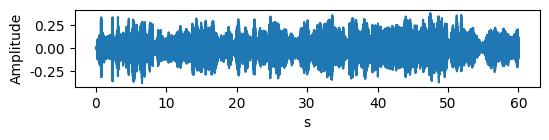

data processing end!


In [19]:
# - * - coding: utf-8 - * -
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

plt.figure(dpi=1080) # 将显示的所有图分辨率调高
# matplotlib.rc("font",family='SimHei') # 显示中文
matplotlib.rcParams['axes.unicode_minus']=False # 显示符号


def displayWaveform(wav_path): # 显示语音时域波形
    """
    display waveform of a given speech sample
    :param sample_name: speech sample name
    :param fs: sample frequency
    :return:
    """
    plt.figure(figsize=(6, 1)) # set the figure size
    samples, sr = librosa.load(wav_path, sr=16000)
    # samples = samples[6000:16000]

    print(len(samples), sr)
    time = np.arange(0, len(samples)) * (1.0 / sr)

    plt.plot(time, samples)
    # plt.title("语音信号时域波形")
    plt.xlabel("s")
    plt.ylabel("Amplitude")
    plt.savefig("./data/audio/00002335wavform.png", dpi=600, bbox_inches = 'tight')
    plt.show()

def displaySpectrum(): # 显示语音频域谱线
    x, sr = librosa.load(r'your wav file path', sr=16000)
    print(len(x))
    # ft = librosa.stft(x)
    # magnitude = np.abs(ft)  # 对fft的结果直接取模（取绝对值），得到幅度magnitude
    # frequency = np.angle(ft)  # (0, 16000, 121632)

    ft = fft(x)
    print(len(ft), type(ft), np.max(ft), np.min(ft))
    magnitude = np.absolute(ft)  # 对fft的结果直接取模（取绝对值），得到幅度magnitude
    frequency = np.linspace(0, sr, len(magnitude))  # (0, 16000, 121632)

    print(len(magnitude), type(magnitude), np.max(magnitude), np.min(magnitude))
    print(len(frequency), type(frequency), np.max(frequency), np.min(frequency))

    # plot spectrum，限定[:40000]
    # plt.figure(figsize=(18, 8))
    plt.plot(frequency[:40000], magnitude[:40000])  # magnitude spectrum
    plt.title("语音信号频域谱线")
    plt.xlabel("频率（赫兹）")
    plt.ylabel("幅度")
    plt.savefig("your dir\语音信号频谱图", dpi=600)
    plt.show()

    # # plot spectrum，不限定 [对称]
    # plt.figure(figsize=(18, 8))
    # plt.plot(frequency, magnitude)  # magnitude spectrum
    # plt.title("语音信号频域谱线")
    # plt.xlabel("频率（赫兹）")
    # plt.ylabel("幅度")
    # plt.show()


def displaySpectrogram():
    x, sr = librosa.load(r'your wav file path', sr=16000)

    # compute power spectrogram with stft(short-time fourier transform):
    # 基于stft，计算power spectrogram
    spectrogram = librosa.amplitude_to_db(librosa.stft(x))

    # show
    librosa.display.specshow(spectrogram, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('语音信号对数谱图')
    plt.xlabel('时长（秒）')
    plt.ylabel('频率（赫兹）')
    plt.show()


if __name__ == '__main__':
    wav_path = './data/audio/00002335.wav'
    displayWaveform(wav_path)
    # displaySpectrum()
    # displaySpectrogram()
    print('data processing end!')